
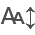

In [51]:
import polars as pl
import pandas as pd
import polars.selectors as cs

from catboost import CatBoostRegressor, CatBoostClassifier, metrics, cv, Pool

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [2]:
df = pl.read_csv('data/Aging_prediction_dataset.csv')
df

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [3]:
df.group_by('gender').agg(pl.col('age').mean())

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


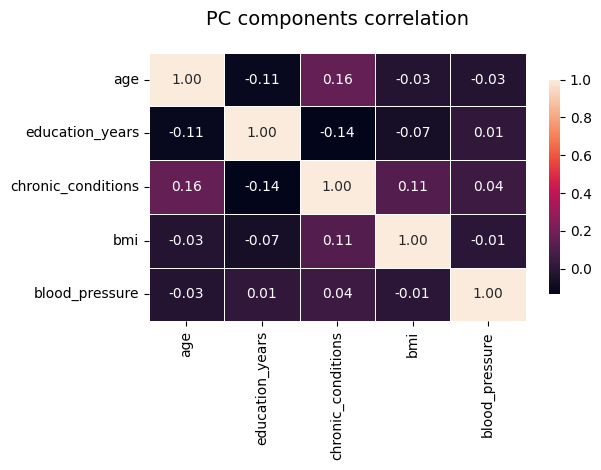

In [5]:
df_corr = df[['age', 'education_years', 'chronic_conditions', 'bmi', 'blood_pressure']].to_pandas().corr()
sns.heatmap(
    df_corr,
    annot=True,               # Show values in cells
    fmt=".2f",                # Format annotations to 2 decimals
    #cmap="coolwarm",          # Color palette (try "viridis", "magma")
    linewidths=0.5,           # Add grid lines
    linecolor="white",        # Grid line color
    cbar=True,                # Show color bar
    cbar_kws={"shrink": 0.8}  # Adjust color bar size
)
plt.title("PC components correlation", fontsize=14, pad=20)  # Title with padding
plt.tight_layout()
plt.show()

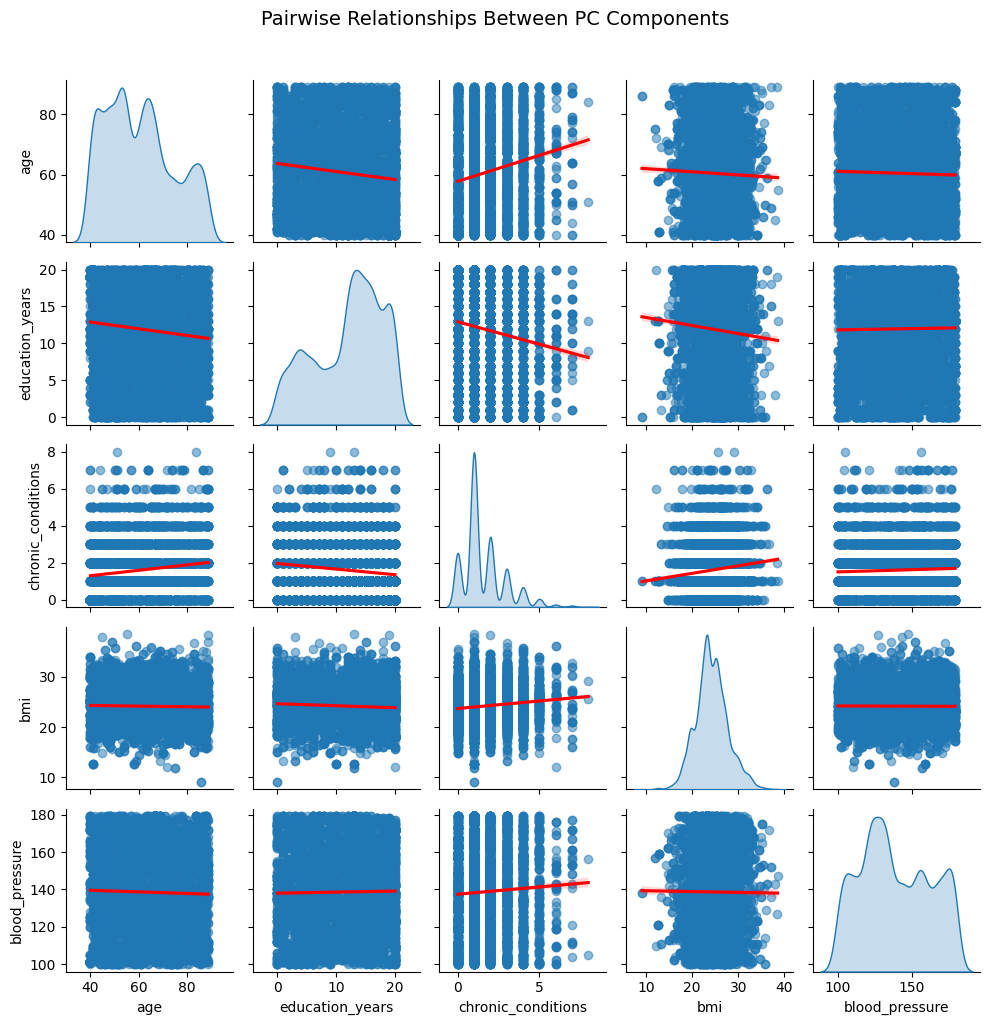

In [6]:
df1 = df[['age', 'education_years', 'chronic_conditions', 'bmi', 'blood_pressure']].to_pandas()

# Create pairplot
pairplot = sns.pairplot(
    df1,
    kind='reg',          # Show regression lines ('scatter' for points only)
    diag_kind='kde',     # Diagonal plots: 'kde' for density, 'hist' for histogram
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}},
    corner=False,        # Show upper triangle only if True
    height=2             # Height of each subplot
)

# Add title (requires manual adjustment)
pairplot.fig.suptitle("Pairwise Relationships Between PC Components", 
                     y=1.02, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

In [66]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        # iterations=1_000,
        # learning_rate=0.05,
        # #eval_metric= 'AUC',
        # eval_metric= 'WKappa', #'Accuracy',# 'AUC:type=Mu', #  #
        # #loss_function='MultiClass',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True
    )


grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth':[2, 5, 7],
    'l2_leaf_reg': [1, 4, 6],
    'logging_level':['Silent'],
   # 'eval_metric': ['WKappa', 'Accuracy', 'AUC:type=Mu']
}

def grid_search_model(train_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1500,
        eval_metric='AUC',
        #eval_metric= 'TotalF1', # 'TotalF1', #'F1', 'TotalF1',
        **kwargs
    )

    return model.grid_search(
        grid,
        train_pool,
        verbose=0,
        shuffle=False,
        plot=True
    )

In [67]:
df.head()

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [68]:
df['aging_outcome'].value_counts()

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [69]:
replacement_ls = {'At-risk':1, 'Healthy':2, 'Frail':2}

y = df.with_columns(
    pl.col("aging_outcome").replace(replacement_ls).alias("category_code")
).to_pandas()['category_code']
y

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [70]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop('aging_outcome').to_pandas(), y, test_size=0.33, random_state=42)

In [71]:
train_pool = Pool(X_train, y_train, cat_features=['gender', 'income_level', 'physical_activity', 'smoking_status', 'diet_quality', 'alcohol_consumption', 'social_engagement'])
test_pool = Pool(X_test, y_test, cat_features=['gender', 'income_level', 'physical_activity', 'smoking_status', 'diet_quality', 'alcohol_consumption', 'social_engagement'])

In [72]:
grid_search = grid_search_model(train_pool,  task_type='CPU')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

![](./img1.png)

In [73]:
grid_search['params']

{'depth': 7,
 'logging_level': 'Silent',
 'learning_rate': 0.05,
 'l2_leaf_reg': 6}

In [74]:
params = {
    'eval_metric': 'AUC',
    'iterations': 500,
    'depth': 7, 
    'learning_rate': 0.05,
    'l2_leaf_reg': 6,
    'task_type': 'CPU'
}
model = fit_model(train_pool, test_pool, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7818379	best: 0.7818379 (0)	total: 7.78ms	remaining: 3.88s
100:	test: 0.9982358	best: 0.9982358 (100)	total: 372ms	remaining: 1.47s
200:	test: 0.9995356	best: 0.9995414 (197)	total: 720ms	remaining: 1.07s
300:	test: 0.9997522	best: 0.9997566 (271)	total: 1.09s	remaining: 720ms
400:	test: 0.9998725	best: 0.9998725 (400)	total: 1.47s	remaining: 364ms
499:	test: 0.9998739	best: 0.9998906 (449)	total: 1.84s	remaining: 0us

bestTest = 0.9998905987
bestIteration = 449

Shrink model to first 450 iterations.


![](./img2.png)

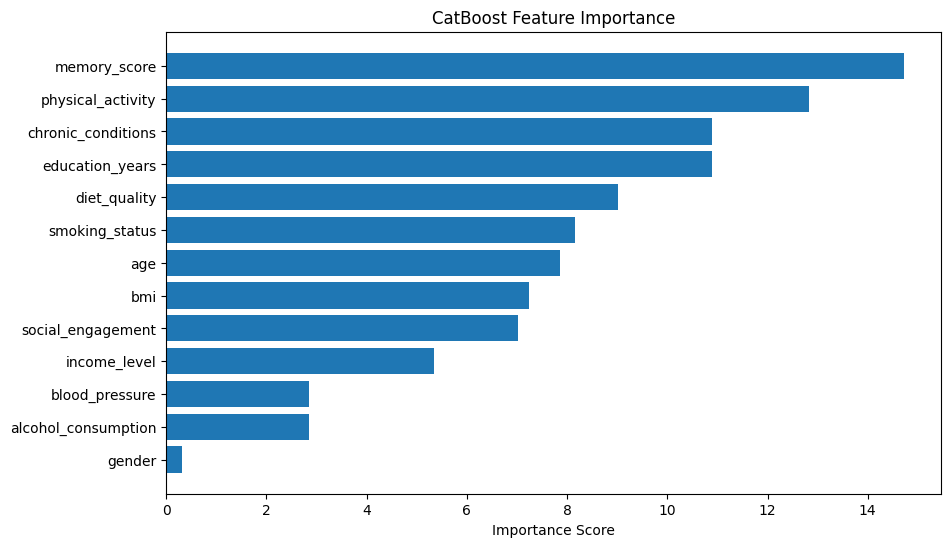

In [75]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() 
plt.show()